# Pix2Pix로 Segmentation Map에서 실제 거리 이미지 생성하기

- Pix2Pix 모델을 사용해 Segmentation Map 이미지에서 실제 거리 이미지를 생성해보자.

## Pix2Pix 생성자
- 입력 : 이미지
- 출력 : 변환된 이미지
> 입력 이미지와 변환된 이미지 크기는 동일해야
- Encoder-Decoder 구조에 U-Net의 Skip Connection을 사용
### Encoder
- 입력 이미지의 사이즈를 줄여가면서 입력 이미지에서 중요한 representation 학습
- `bottleneck` : 인코더의 최종 출력 부분. 입력 이미지의 가장 중요한 특징만 담고 있음
> but, `bottleneck` 정보 만으로는 변환된 이미지 생성하기 부족!
### Decoder
- 입력 이미지와 동일 크기의 변환된 이미지 생성
### U-Net 구조
- 각 레이어별 Encoder와 Decoder가 Skip connection으로 연결되어 있음
- down-sampling 된 `bottleneck` 정보에 각 레이어별 Encoder에서 추가 정보를 받아 더 선명한 결과를 얻을 수 있다.

## Pix2Pix 판별자
- 기존의 DCGAN 판별자가 하나의 이미지에 대해 하나의 확률값을 출력
- 이와 달리 Pix2Pix 판별자는 하나의 이미지의 일부 영역 별로 여러 개의 확률값을 출력
- 하나의 이미지 안에서도 먼 거리에 있는 픽셀들은 서로 연관성이 없다! 
    - 👉 일정 사이즈의 패치마다 가짜인지 진짜인지 확률값을 도출한다
- 여러 출력값들의 평균으로 최종 판별자의 출력을 생성
![pix2pix 판별자](https://d3s0tskafalll9.cloudfront.net/media/images/patchgan.max-800x600.png)

In [1]:
# 항상 하는 미친짓 ^^ 
import time
start_time = time.time()

# step1) 데이터 로드 및 전처리

## 1-1. train set 이미지 확인

학습용 데이터 셋에는 100장의 이미지가 있다.

In [2]:
import os

data_path = 'C:/Users/Noah/aiffel/E17/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


- 임의로 6장의 데이터를 시각화해보자.
- 왼쪽에는 실제 도로 이미지가, 오른쪽에는 Segmentation Map 이미지가 있다.

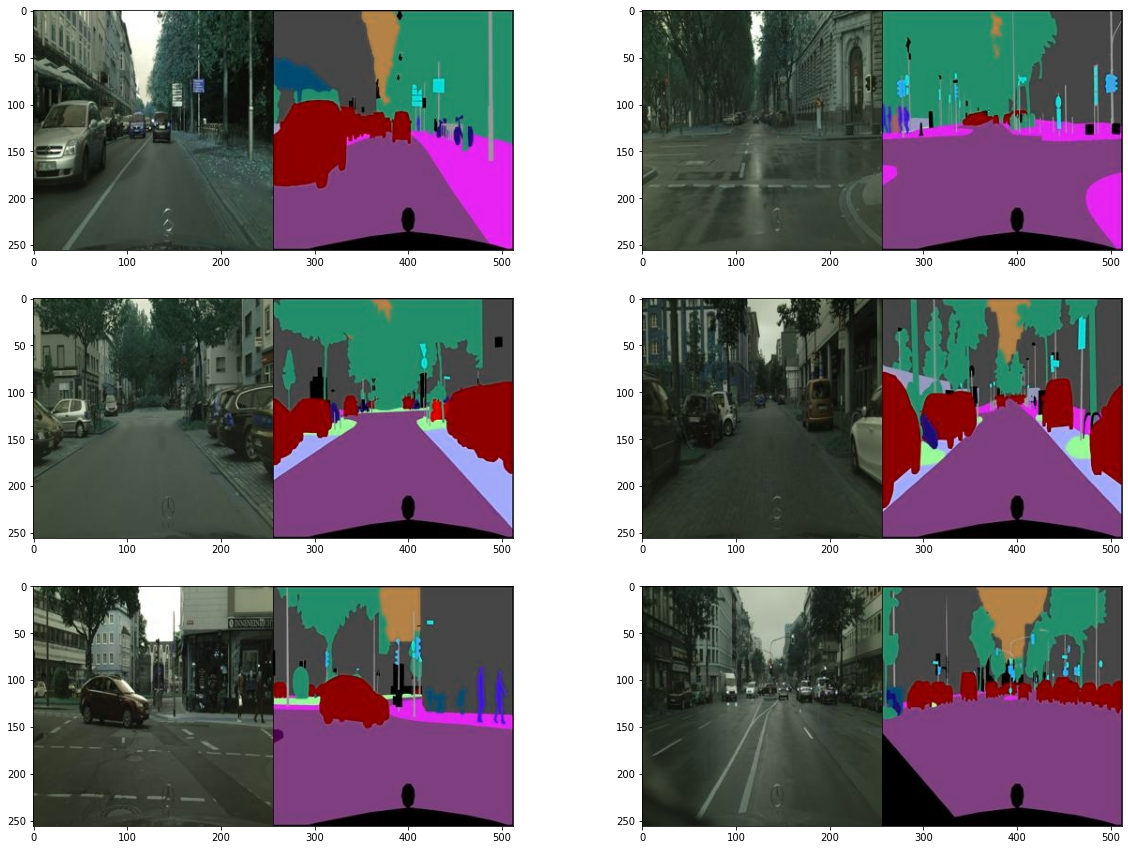

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 이미지 크기
- 한 장의 이미지가 (256, 512, 3) 사이즈 이다.
- 이를 (256, 256, 3) 사이즈의 이미지 2개로 분할해 사용한다.

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## 1-2. 이미지 Segmantation map, Road Image로 나누기

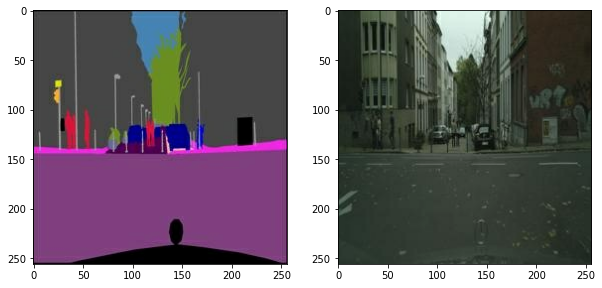

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    road = img[:, :w, :] 
    road = tf.cast(road, tf.float32)
    segmap = img[:, w:, :] 
    segmap = tf.cast(segmap, tf.float32)
    return normalize(segmap), normalize(road)

f = data_path + os.listdir(data_path)[1]
segmap, road = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segmap))
plt.subplot(1,2,2); plt.imshow(denormalize(road))

## 1-3. 데이터 증강

- def `apply_augmentation` : 도로 이미지와 해당 이미지의 Segmentation Map을 입력으로 받아 여러가지 데이터 증강 연산을 두 이미지에 동일하게 적용

- 두 이미지를 채널 축을 기준으로 연결 (256, 256, 3) + (256, 256, 3) -> (256, 256, 6)
- 50%의 확률로 reflect나 constant 패딩 적용
- `tf.image.random_crop()` : (256,256,6) 사이즈를 가지도록 랜덤으로 자르기
- `tf.image.random_flip_left_right()` : 50%의 확률로 좌우 반전
- `tf.image.random_flip_up_down()` : 50%의 확률로 상하 반전
- `tf.image.rot90()` : 50% 확률로 90도 회전

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(segmap, road):
    segmap = tf.concat([segmap, road], axis=-1) # 마지막 채널 축으로 연결
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(segmap, _pad, "REFLECT")
    else:
        padded = tf.pad(segmap, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

- 제대로 증강된 결과를 확인할 수 있다.

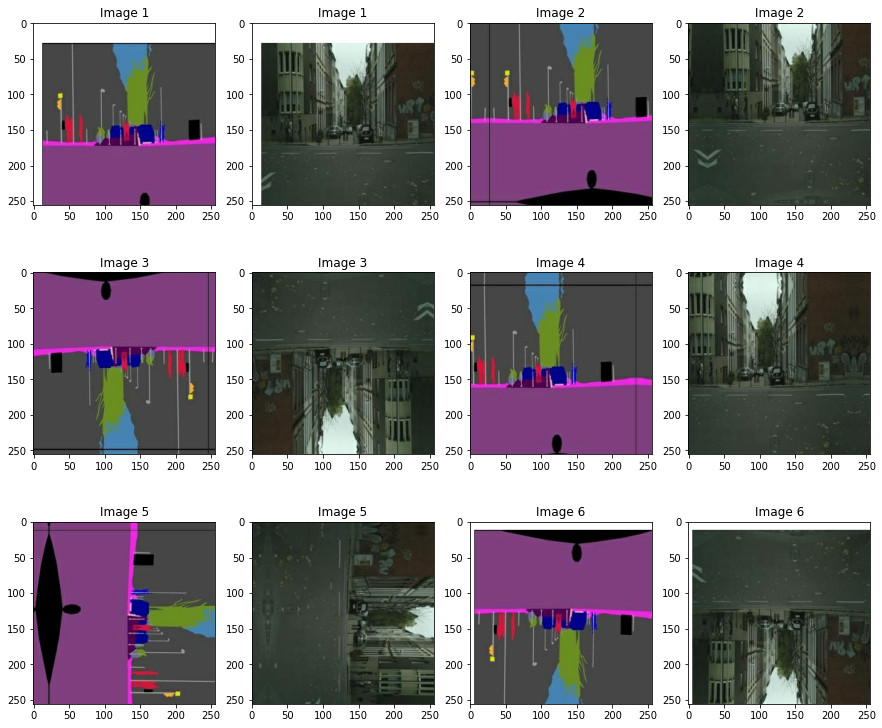

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segmap, augmented_road = apply_augmentation(segmap, road)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segmap)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_road)); plt.title(f"Image {img_n}")
    img_n += 1

## 1-4. train 데이터셋 생성
- def `get_train(path)`: 이미지를 불러오고 데이터 증강 함수를 적용해 train set을 구성한다.

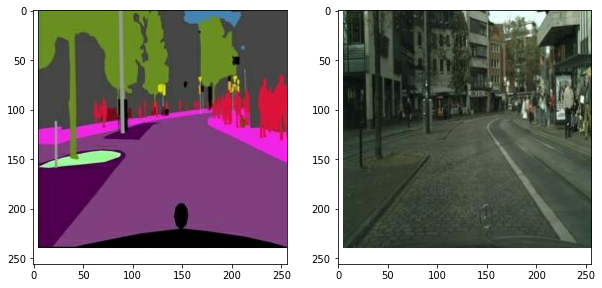

In [8]:
from tensorflow import data

def get_train(img_path):
    segmap, road = load_img(img_path)
    segmap, road = apply_augmentation(segmap, road)
    return segmap, road

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segmap, road = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segmap[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(road[0].astype(np.uint8))

# step2) Pix2Pix 모델 정의

## 2-1. Pix2Pix 생성자 구성
![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png)

### Encoder 블록 정의
- 우선 Conv->BN->LeakyReLU를 하나의 블록으로 구성

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    # 사용할 필터 개수, BN 사용 여부 결정
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


### 실제 Encoder 구성
- `filters[]` : 각 블록에서 사용할 필터 개수를 저장
- 블록 통과할 수록 이미지 (w,h) 크기 절반씩 감소
- 사용된 필터 개수는 64개 에서 512개로 증가

In [10]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0: # 첫번째 블록은 BN 사용 안함
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)): # 구성 레이어 확인
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- Encoder 형태 확인

In [11]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

### Decoder 블록 정의
- Conv -> BN -> 50% 확률로 Dropout -> ReLU

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### 실제 Decoder 구성
- 이미지 (w,h) 크기는 점점 증가
- 필터 개수는 점점 감소
- 최종 출력은 (256, 256, 3)

In [13]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3: # 처음 3개 블록만 Dropout 사용
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- 모델 출력 형태 확인

In [14]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

# Generator에 U-Net 구조 적용
- 앞서 생성한 Encoder에서 마지막 레이어의 출력을 제외하고 저장
- Decoder에 각 계층 별 Encoder의 출력을 함께 입력으로 받음
- Decoder의 입력 채널 수가 늘어나서 Convolution 레이어에서 사용하는 필터 크기도 증가
- 단순 Encoder-Decoder에 비해 학습해야 할 파라미터 개수 증가.

In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # skip connection을 위해 각 Encoder 레이어에서의 출력 저장
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        
        # Encoder의 마지막에서 두번째 출력과 Decoder의 첫 레이어 연결
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            # 마지막 축인 채널축을 기준으로 서로 연결
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [16]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_8 (EncodeBlock)   (None, 128, 128, 64  3072        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_9 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block_8[0][0]']         
                                                                                            

## 2-2. Pix2Pix 판별자 구성

## 판별자 구성 요소
- 판별을 위해 sigmoid 사용
![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_d.max-800x600.png)
- 입력 : 진짜 이미지, 생성된 이미지
- 두개 입력 연결 -> Encoder 블록 5개 -> 1차원 출력 블록

- 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소
1. 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)
    - w,h 양쪽에 1씩 패딩 -> 총 2만큼 크기 증가
2. Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)
    - 패딩 없이 필터 크기 4, stride 1인 Conv 거쳐서 (w, h) 3씩 감소
    - $$출력크기 = \frac{(입력크기+2*패딩사이즈-필터크기)}{스트라이드+1}$$
    - 채널수 = 사용한 필터 개수
3. BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)
4. LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)
    - BN, LeakyReLU는 출력에 영향 x

In [17]:
class DiscBlock(layers.Layer):
    # 필터 개수, stride 간격, 출력 피쳐맵 크기 조절, BN 사용 여부, 활성화 함수 사용 여부 결정
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_30 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [20]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

- (256,256,3) 입력 넣을 때 (30,30) 출력 되는지 확인

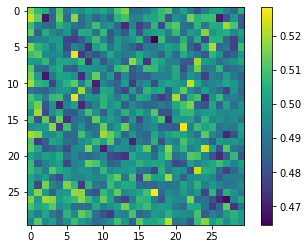

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# step3) 모델 학습

## 3-1. 손실함수 정의
- L1이랑 cGAN loss 사용 시 가장 좋은 결과

In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    # 가짜이미지 - 실제 이미지 간 MAE 계산(L1 loss)
    l1_loss = mae(real_output, fake_output)
    # 가짜 이미지랑 실제 이미지 비교
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    # 실제 이미지는 1로 채워진 벡터와 비교
    # 가짜 이미지는 0으로 채워진 벡터와 비교
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

## 3-2. Optimizer 정의
- Adam 사용

In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

## 3-3. step별 가중치 업데이트
배치 하나 크기 만큼 데이터 입력 시 가중치 1회 업데이트

In [24]:
@tf.function
def train_step(segmap, real_road):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_road = generator(segmap, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segmap, fake_road, training=True)
        real_disc = discriminator(segmap, real_road, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_road, real_road, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

## 3-4. 학습 수행
- 실제 학습 진행

In [25]:
EPOCHS = 1000 

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[],'l1_loss':[],'disc_loss':[]}
for epoch in range(1, EPOCHS+1):
    for i, (segmap, road) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmap, road)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
                
        # 200회 반복마다 손실을 출력합니다.
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:0.3887                     
L1_loss:0.1736                     
Discriminator_loss:1.5473

EPOCH[2] - STEP[200]                     
Generator_loss:1.7199                     
L1_loss:0.2116                     
Discriminator_loss:0.4424

EPOCH[3] - STEP[200]                     
Generator_loss:1.6606                     
L1_loss:0.1612                     
Discriminator_loss:1.1277

EPOCH[4] - STEP[200]                     
Generator_loss:1.1419                     
L1_loss:0.1506                     
Discriminator_loss:0.6714

EPOCH[5] - STEP[200]                     
Generator_loss:1.8506                     
L1_loss:0.1919                     
Discriminator_loss:0.2761

EPOCH[6] - STEP[200]                     
Generator_loss:1.6151                     
L1_loss:0.1738                     
Discriminator_loss:0.5227

EPOCH[7] - STEP[200]                     
Generator_loss:1.2026                     
L1_loss:0.2181             

EPOCH[57] - STEP[200]                     
Generator_loss:1.7628                     
L1_loss:0.1601                     
Discriminator_loss:0.9641

EPOCH[58] - STEP[200]                     
Generator_loss:2.2802                     
L1_loss:0.1610                     
Discriminator_loss:1.3167

EPOCH[59] - STEP[200]                     
Generator_loss:1.6041                     
L1_loss:0.1664                     
Discriminator_loss:0.7793

EPOCH[60] - STEP[200]                     
Generator_loss:2.2186                     
L1_loss:0.1672                     
Discriminator_loss:1.3195

EPOCH[61] - STEP[200]                     
Generator_loss:2.0761                     
L1_loss:0.1744                     
Discriminator_loss:0.3582

EPOCH[62] - STEP[200]                     
Generator_loss:0.5220                     
L1_loss:0.1635                     
Discriminator_loss:1.6648

EPOCH[63] - STEP[200]                     
Generator_loss:1.9877                     
L1_loss:0.1526      

EPOCH[112] - STEP[200]                     
Generator_loss:0.5851                     
L1_loss:0.1773                     
Discriminator_loss:1.1702

EPOCH[113] - STEP[200]                     
Generator_loss:2.0731                     
L1_loss:0.1734                     
Discriminator_loss:0.5098

EPOCH[114] - STEP[200]                     
Generator_loss:1.2950                     
L1_loss:0.2054                     
Discriminator_loss:0.4345

EPOCH[115] - STEP[200]                     
Generator_loss:0.5664                     
L1_loss:0.1627                     
Discriminator_loss:1.0235

EPOCH[116] - STEP[200]                     
Generator_loss:2.6336                     
L1_loss:0.1463                     
Discriminator_loss:0.3969

EPOCH[117] - STEP[200]                     
Generator_loss:1.7121                     
L1_loss:0.1685                     
Discriminator_loss:2.1755

EPOCH[118] - STEP[200]                     
Generator_loss:1.4045                     
L1_loss:0.158

EPOCH[167] - STEP[200]                     
Generator_loss:1.2643                     
L1_loss:0.1499                     
Discriminator_loss:1.6109

EPOCH[168] - STEP[200]                     
Generator_loss:1.1727                     
L1_loss:0.1741                     
Discriminator_loss:0.5211

EPOCH[169] - STEP[200]                     
Generator_loss:1.2137                     
L1_loss:0.1472                     
Discriminator_loss:1.2306

EPOCH[170] - STEP[200]                     
Generator_loss:0.9561                     
L1_loss:0.1293                     
Discriminator_loss:0.9712

EPOCH[171] - STEP[200]                     
Generator_loss:1.9631                     
L1_loss:0.1760                     
Discriminator_loss:0.2906

EPOCH[172] - STEP[200]                     
Generator_loss:1.0014                     
L1_loss:0.2049                     
Discriminator_loss:0.5922

EPOCH[173] - STEP[200]                     
Generator_loss:0.7505                     
L1_loss:0.209

EPOCH[222] - STEP[200]                     
Generator_loss:0.8735                     
L1_loss:0.1601                     
Discriminator_loss:0.8060

EPOCH[223] - STEP[200]                     
Generator_loss:1.2574                     
L1_loss:0.1615                     
Discriminator_loss:0.5042

EPOCH[224] - STEP[200]                     
Generator_loss:0.1925                     
L1_loss:0.1685                     
Discriminator_loss:2.0357

EPOCH[225] - STEP[200]                     
Generator_loss:2.4036                     
L1_loss:0.1832                     
Discriminator_loss:0.1635

EPOCH[226] - STEP[200]                     
Generator_loss:0.6342                     
L1_loss:0.1534                     
Discriminator_loss:1.1463

EPOCH[227] - STEP[200]                     
Generator_loss:1.2683                     
L1_loss:0.1703                     
Discriminator_loss:0.6223

EPOCH[228] - STEP[200]                     
Generator_loss:1.5782                     
L1_loss:0.160

EPOCH[277] - STEP[200]                     
Generator_loss:3.1547                     
L1_loss:0.1571                     
Discriminator_loss:2.8015

EPOCH[278] - STEP[200]                     
Generator_loss:1.0410                     
L1_loss:0.1779                     
Discriminator_loss:0.6797

EPOCH[279] - STEP[200]                     
Generator_loss:2.0559                     
L1_loss:0.1704                     
Discriminator_loss:0.6590

EPOCH[280] - STEP[200]                     
Generator_loss:2.1093                     
L1_loss:0.1597                     
Discriminator_loss:1.1218

EPOCH[281] - STEP[200]                     
Generator_loss:1.5668                     
L1_loss:0.1868                     
Discriminator_loss:0.3907

EPOCH[282] - STEP[200]                     
Generator_loss:1.3808                     
L1_loss:0.1437                     
Discriminator_loss:0.6522

EPOCH[283] - STEP[200]                     
Generator_loss:1.0271                     
L1_loss:0.148

EPOCH[332] - STEP[200]                     
Generator_loss:1.5541                     
L1_loss:0.1544                     
Discriminator_loss:0.6374

EPOCH[333] - STEP[200]                     
Generator_loss:1.4255                     
L1_loss:0.1370                     
Discriminator_loss:1.5411

EPOCH[334] - STEP[200]                     
Generator_loss:1.0987                     
L1_loss:0.1526                     
Discriminator_loss:1.6880

EPOCH[335] - STEP[200]                     
Generator_loss:2.1964                     
L1_loss:0.1417                     
Discriminator_loss:0.9381

EPOCH[336] - STEP[200]                     
Generator_loss:0.8807                     
L1_loss:0.1601                     
Discriminator_loss:0.8779

EPOCH[337] - STEP[200]                     
Generator_loss:1.1239                     
L1_loss:0.1737                     
Discriminator_loss:1.4752

EPOCH[338] - STEP[200]                     
Generator_loss:1.1808                     
L1_loss:0.197

EPOCH[387] - STEP[200]                     
Generator_loss:3.0160                     
L1_loss:0.1499                     
Discriminator_loss:2.0935

EPOCH[388] - STEP[200]                     
Generator_loss:1.3975                     
L1_loss:0.1498                     
Discriminator_loss:0.6172

EPOCH[389] - STEP[200]                     
Generator_loss:1.6623                     
L1_loss:0.1515                     
Discriminator_loss:0.5264

EPOCH[390] - STEP[200]                     
Generator_loss:2.0684                     
L1_loss:0.1512                     
Discriminator_loss:0.5820

EPOCH[391] - STEP[200]                     
Generator_loss:2.0562                     
L1_loss:0.1575                     
Discriminator_loss:1.2200

EPOCH[392] - STEP[200]                     
Generator_loss:1.0325                     
L1_loss:0.1792                     
Discriminator_loss:0.6555

EPOCH[393] - STEP[200]                     
Generator_loss:1.5769                     
L1_loss:0.141

EPOCH[442] - STEP[200]                     
Generator_loss:1.5367                     
L1_loss:0.1365                     
Discriminator_loss:0.8650

EPOCH[443] - STEP[200]                     
Generator_loss:2.5199                     
L1_loss:0.1412                     
Discriminator_loss:0.9123

EPOCH[444] - STEP[200]                     
Generator_loss:1.9262                     
L1_loss:0.1389                     
Discriminator_loss:1.9143

EPOCH[445] - STEP[200]                     
Generator_loss:1.7776                     
L1_loss:0.1336                     
Discriminator_loss:1.5752

EPOCH[446] - STEP[200]                     
Generator_loss:1.7807                     
L1_loss:0.1551                     
Discriminator_loss:1.1187

EPOCH[447] - STEP[200]                     
Generator_loss:0.6771                     
L1_loss:0.1780                     
Discriminator_loss:0.9825

EPOCH[448] - STEP[200]                     
Generator_loss:1.3281                     
L1_loss:0.160

EPOCH[497] - STEP[200]                     
Generator_loss:0.6912                     
L1_loss:0.1718                     
Discriminator_loss:1.1404

EPOCH[498] - STEP[200]                     
Generator_loss:2.8457                     
L1_loss:0.1312                     
Discriminator_loss:1.5705

EPOCH[499] - STEP[200]                     
Generator_loss:0.8522                     
L1_loss:0.1465                     
Discriminator_loss:0.9158

EPOCH[500] - STEP[200]                     
Generator_loss:1.1616                     
L1_loss:0.1635                     
Discriminator_loss:0.7540

EPOCH[501] - STEP[200]                     
Generator_loss:0.8384                     
L1_loss:0.1468                     
Discriminator_loss:1.0374

EPOCH[502] - STEP[200]                     
Generator_loss:1.1587                     
L1_loss:0.1421                     
Discriminator_loss:1.2307

EPOCH[503] - STEP[200]                     
Generator_loss:1.0095                     
L1_loss:0.142

EPOCH[552] - STEP[200]                     
Generator_loss:0.8766                     
L1_loss:0.2051                     
Discriminator_loss:0.7446

EPOCH[553] - STEP[200]                     
Generator_loss:1.9741                     
L1_loss:0.1483                     
Discriminator_loss:1.3466

EPOCH[554] - STEP[200]                     
Generator_loss:1.0075                     
L1_loss:0.1387                     
Discriminator_loss:0.7876

EPOCH[555] - STEP[200]                     
Generator_loss:1.8675                     
L1_loss:0.1500                     
Discriminator_loss:1.1768

EPOCH[556] - STEP[200]                     
Generator_loss:2.2158                     
L1_loss:0.1266                     
Discriminator_loss:1.7698

EPOCH[557] - STEP[200]                     
Generator_loss:2.2811                     
L1_loss:0.1189                     
Discriminator_loss:1.0431

EPOCH[558] - STEP[200]                     
Generator_loss:1.1258                     
L1_loss:0.150

EPOCH[607] - STEP[200]                     
Generator_loss:1.6028                     
L1_loss:0.1880                     
Discriminator_loss:0.4197

EPOCH[608] - STEP[200]                     
Generator_loss:1.5192                     
L1_loss:0.1579                     
Discriminator_loss:0.4818

EPOCH[609] - STEP[200]                     
Generator_loss:2.3502                     
L1_loss:0.1711                     
Discriminator_loss:0.5009

EPOCH[610] - STEP[200]                     
Generator_loss:1.2396                     
L1_loss:0.1560                     
Discriminator_loss:0.5710

EPOCH[611] - STEP[200]                     
Generator_loss:1.3220                     
L1_loss:0.1347                     
Discriminator_loss:0.7337

EPOCH[612] - STEP[200]                     
Generator_loss:1.8217                     
L1_loss:0.1666                     
Discriminator_loss:0.3728

EPOCH[613] - STEP[200]                     
Generator_loss:2.6381                     
L1_loss:0.121

EPOCH[662] - STEP[200]                     
Generator_loss:1.6279                     
L1_loss:0.1429                     
Discriminator_loss:0.5456

EPOCH[663] - STEP[200]                     
Generator_loss:0.9093                     
L1_loss:0.1373                     
Discriminator_loss:0.9718

EPOCH[664] - STEP[200]                     
Generator_loss:1.2493                     
L1_loss:0.1557                     
Discriminator_loss:0.7746

EPOCH[665] - STEP[200]                     
Generator_loss:1.2534                     
L1_loss:0.1259                     
Discriminator_loss:0.7790

EPOCH[666] - STEP[200]                     
Generator_loss:1.5053                     
L1_loss:0.1376                     
Discriminator_loss:0.8476

EPOCH[667] - STEP[200]                     
Generator_loss:1.5109                     
L1_loss:0.1439                     
Discriminator_loss:0.9645

EPOCH[668] - STEP[200]                     
Generator_loss:2.6941                     
L1_loss:0.152

EPOCH[717] - STEP[200]                     
Generator_loss:3.2052                     
L1_loss:0.1326                     
Discriminator_loss:0.6221

EPOCH[718] - STEP[200]                     
Generator_loss:1.4169                     
L1_loss:0.1277                     
Discriminator_loss:0.9475

EPOCH[719] - STEP[200]                     
Generator_loss:1.1266                     
L1_loss:0.1586                     
Discriminator_loss:0.7891

EPOCH[720] - STEP[200]                     
Generator_loss:1.8297                     
L1_loss:0.1396                     
Discriminator_loss:0.5800

EPOCH[721] - STEP[200]                     
Generator_loss:1.1436                     
L1_loss:0.1149                     
Discriminator_loss:1.1290

EPOCH[722] - STEP[200]                     
Generator_loss:2.2522                     
L1_loss:0.1281                     
Discriminator_loss:1.5669

EPOCH[723] - STEP[200]                     
Generator_loss:1.8050                     
L1_loss:0.115

EPOCH[772] - STEP[200]                     
Generator_loss:2.3913                     
L1_loss:0.1384                     
Discriminator_loss:0.3582

EPOCH[773] - STEP[200]                     
Generator_loss:1.9875                     
L1_loss:0.1563                     
Discriminator_loss:0.4138

EPOCH[774] - STEP[200]                     
Generator_loss:1.2746                     
L1_loss:0.1536                     
Discriminator_loss:0.8599

EPOCH[775] - STEP[200]                     
Generator_loss:2.3303                     
L1_loss:0.1155                     
Discriminator_loss:0.3193

EPOCH[776] - STEP[200]                     
Generator_loss:2.6772                     
L1_loss:0.1470                     
Discriminator_loss:0.5178

EPOCH[777] - STEP[200]                     
Generator_loss:3.4582                     
L1_loss:0.1244                     
Discriminator_loss:1.0406

EPOCH[778] - STEP[200]                     
Generator_loss:2.1764                     
L1_loss:0.139

EPOCH[827] - STEP[200]                     
Generator_loss:2.4539                     
L1_loss:0.1385                     
Discriminator_loss:0.7970

EPOCH[828] - STEP[200]                     
Generator_loss:2.5133                     
L1_loss:0.1294                     
Discriminator_loss:1.4185

EPOCH[829] - STEP[200]                     
Generator_loss:1.9763                     
L1_loss:0.1421                     
Discriminator_loss:0.8903

EPOCH[830] - STEP[200]                     
Generator_loss:1.7887                     
L1_loss:0.1409                     
Discriminator_loss:0.4827

EPOCH[831] - STEP[200]                     
Generator_loss:1.8756                     
L1_loss:0.1357                     
Discriminator_loss:1.1889

EPOCH[832] - STEP[200]                     
Generator_loss:1.2640                     
L1_loss:0.1509                     
Discriminator_loss:0.7233

EPOCH[833] - STEP[200]                     
Generator_loss:1.9547                     
L1_loss:0.139

EPOCH[882] - STEP[200]                     
Generator_loss:1.6166                     
L1_loss:0.1272                     
Discriminator_loss:0.8248

EPOCH[883] - STEP[200]                     
Generator_loss:1.2298                     
L1_loss:0.1523                     
Discriminator_loss:0.5956

EPOCH[884] - STEP[200]                     
Generator_loss:1.1195                     
L1_loss:0.1208                     
Discriminator_loss:1.2353

EPOCH[885] - STEP[200]                     
Generator_loss:1.6511                     
L1_loss:0.1655                     
Discriminator_loss:0.3839

EPOCH[886] - STEP[200]                     
Generator_loss:1.1210                     
L1_loss:0.1141                     
Discriminator_loss:0.8888

EPOCH[887] - STEP[200]                     
Generator_loss:1.9472                     
L1_loss:0.1147                     
Discriminator_loss:1.1723

EPOCH[888] - STEP[200]                     
Generator_loss:1.4971                     
L1_loss:0.130

EPOCH[937] - STEP[200]                     
Generator_loss:1.2231                     
L1_loss:0.1506                     
Discriminator_loss:0.7510

EPOCH[938] - STEP[200]                     
Generator_loss:2.0158                     
L1_loss:0.1139                     
Discriminator_loss:0.4921

EPOCH[939] - STEP[200]                     
Generator_loss:2.0980                     
L1_loss:0.1305                     
Discriminator_loss:0.6004

EPOCH[940] - STEP[200]                     
Generator_loss:0.8260                     
L1_loss:0.1301                     
Discriminator_loss:1.0314

EPOCH[941] - STEP[200]                     
Generator_loss:1.7931                     
L1_loss:0.1196                     
Discriminator_loss:1.0467

EPOCH[942] - STEP[200]                     
Generator_loss:1.5475                     
L1_loss:0.1211                     
Discriminator_loss:0.7364

EPOCH[943] - STEP[200]                     
Generator_loss:2.9849                     
L1_loss:0.132

EPOCH[992] - STEP[200]                     
Generator_loss:1.1254                     
L1_loss:0.1459                     
Discriminator_loss:0.7428

EPOCH[993] - STEP[200]                     
Generator_loss:0.7686                     
L1_loss:0.1422                     
Discriminator_loss:1.0574

EPOCH[994] - STEP[200]                     
Generator_loss:2.8942                     
L1_loss:0.1555                     
Discriminator_loss:0.2344

EPOCH[995] - STEP[200]                     
Generator_loss:2.2735                     
L1_loss:0.1765                     
Discriminator_loss:0.5140

EPOCH[996] - STEP[200]                     
Generator_loss:2.0247                     
L1_loss:0.1115                     
Discriminator_loss:0.9020

EPOCH[997] - STEP[200]                     
Generator_loss:1.4365                     
L1_loss:0.1248                     
Discriminator_loss:1.0402

EPOCH[998] - STEP[200]                     
Generator_loss:0.9892                     
L1_loss:0.167

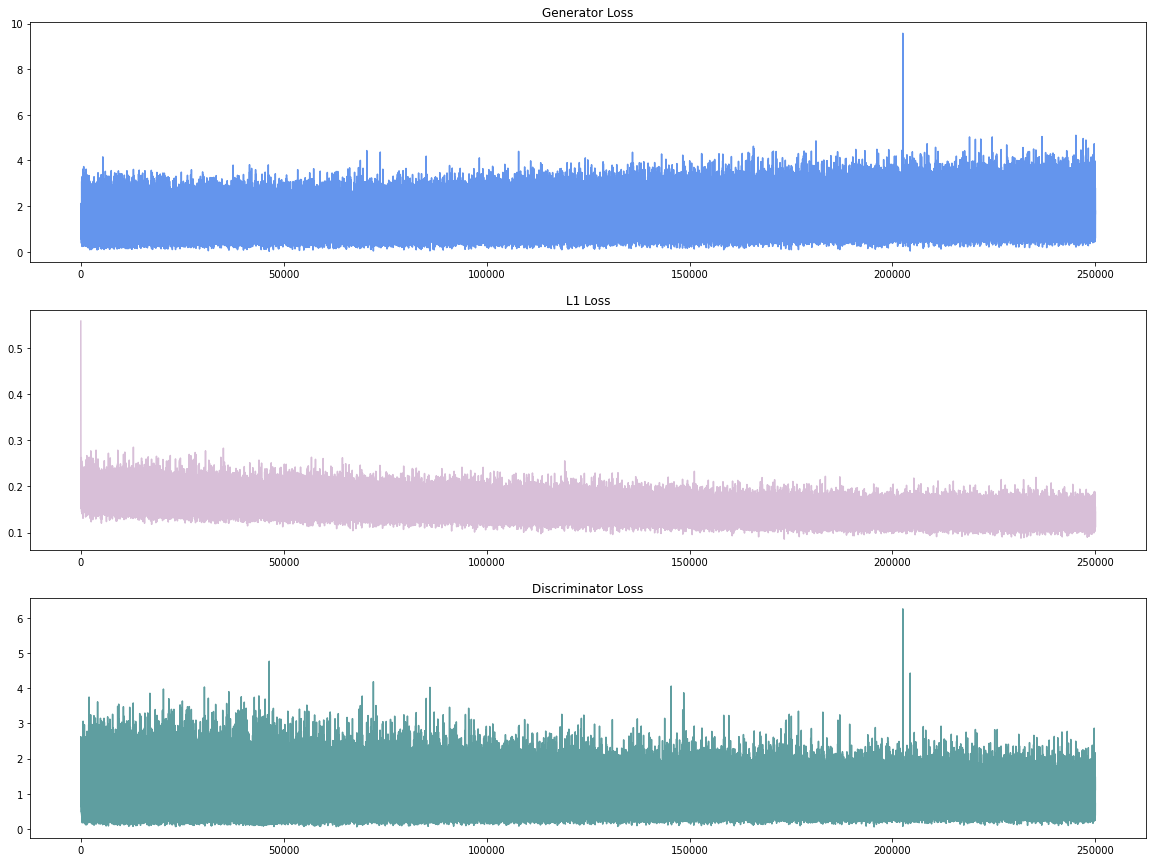

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(history['gen_loss'], color='cornflowerblue')
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'], color='thistle')
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'], color='cadetblue')
plt.title('Discriminator Loss')

plt.show()

# step4) 모델 인퍼런스

In [27]:
test_data_path = 'C:/Users/Noah/aiffel/E17/cityscapes/val/'

In [28]:
test_list = os.listdir(test_data_path)
test_list

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']

In [29]:
def make_road(test_ind):
    f = test_data_path + os.listdir(test_data_path)[test_ind]
    test_segmap, test_road = load_img(f)

    pred = generator(tf.expand_dims(test_segmap, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(test_segmap))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(test_road))
    plt.show()

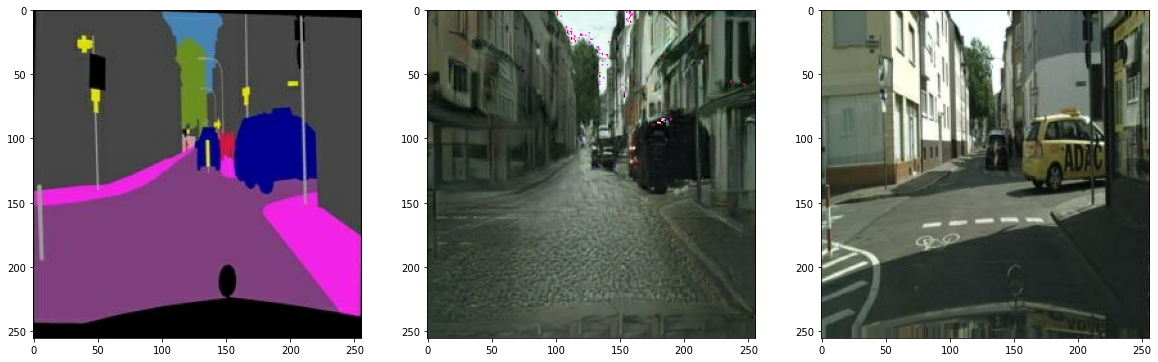

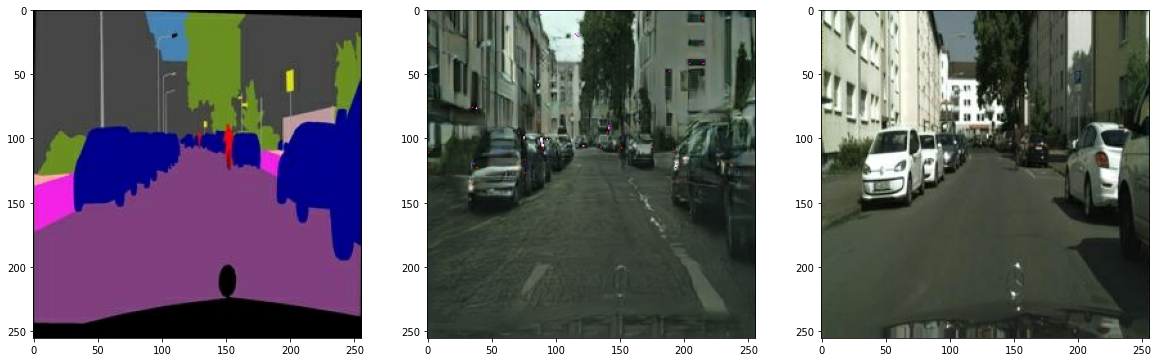

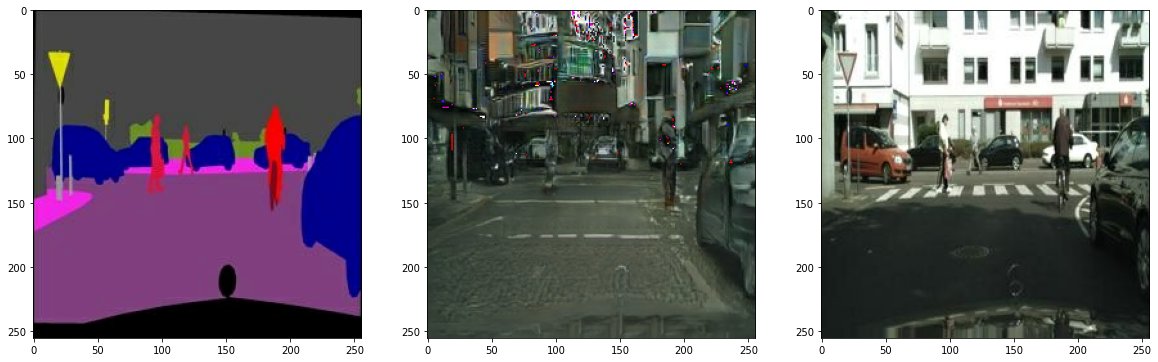

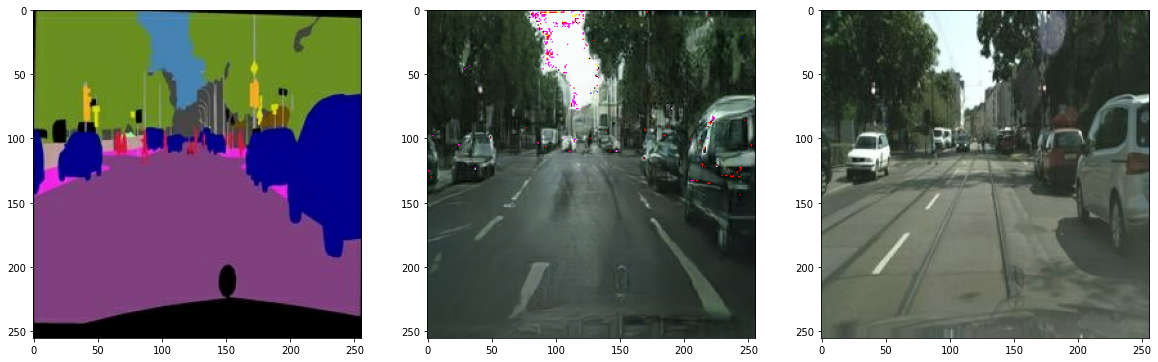

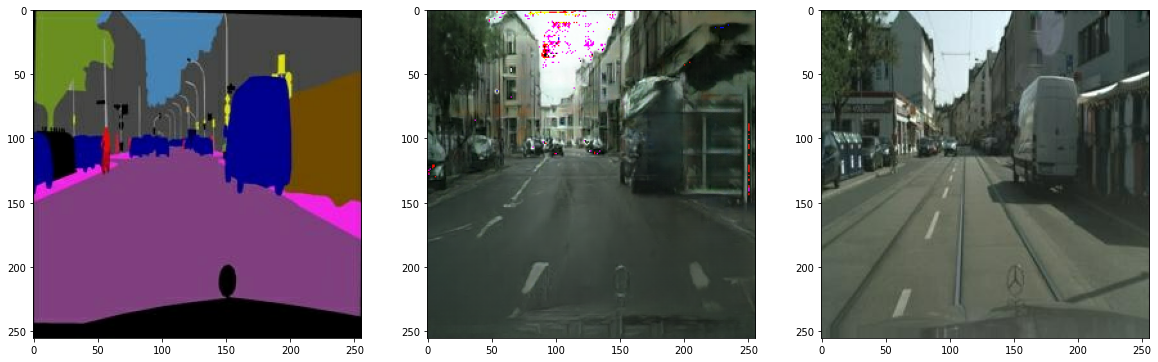

In [30]:
for i in range(5):
    make_road(i)

In [31]:
end_time = time.time()
work_time = round(end_time - start_time)
print(f'총 작업 소요 시간은 약 {work_time}초입니다.')

총 작업 소요 시간은 약 17382초입니다.


- 제법 차 영역에 차 같은 무언가를 생성해내는 모습을 볼 수 있다.
- 이미지 중간 중간에 마젠타 색의 픽셀이 부분 부분 보이는데 왜 생성된건지 궁금하다.
- Segmentation에는 도로 선에 대한 영역 구분이 없는데도 어느 정도 도로 선을 생성하는 모습을 볼 수 있었다.

# 회고
- 이전 노드에서 언급하고 지나갔던 Pix2Pix를 직접 구현해볼 수 있었다.
- 딱히 생성자, 판별자 loss가 수렴하는 모습은 볼 수 없었지만 확실히 에폭 수를 늘리니 더욱 그럴싸한 이미지를 생성해냈다.
- 유의미한 결과를 보려면 얼마나 더 학습량을 늘려야할까. 역시 GAN은 어렵다.

## -프로젝트 정리
(정리) 정말 많은 에폭을 수행해야만 제대로 된 결과물이 나온다는 것을 알고 있다. 
 
 Loss   
- L1 loss는 줄어들었지만 다른 두 loss는 줄어들지 않았다. Discriminator loss는 아주 약간 감소하는 경향을 보이긴 했지만 Generator loss는 전혀 아니었다. Loss에 대해서도 만족스러운 결과가 나오려면 충분히 많은 에폭을 수행하거나 모델 구조에 변화를 주어야 할 것 같다.   

결과(예측한 도로 이미지)   
- 노이즈처럼 나오는 부분이 적었으며 실제 이미지와 아주 똑같진 않아도 segmentation된 사물에 대해서는 제대로 구별하였다. 실제 이미지와 아주 비슷하게 예측하기 위해서는 마찬가지로 충분한 에폭을 수행해야할 것 같다. 